In [1]:
"""
author: Yang
time: 2021.1.27
"""

from random import shuffle
import sndhdr
from turtle import shape
from numpy import dtype
import tensorflow as tf
from utils import *
from sklearn.model_selection import KFold
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())


In [2]:
non_train=readTxt("datasets/non_train.txt")
import random
def sequenceDataEnhance(data,num):
    new_data=[]
    for i in range(num):
        str=''
        for j in range(20):
            index=random.randint(0,len(data)-1)
            start=random.randint(0,190)
            str+=data[index][start:start+10]
        new_data.append(str)
    data.extend(new_data)
    return data
def writeTxt(file,content):
    with open(file,'w',encoding="utf-8") as f:
        return f.write(content)

In [3]:
def removeTestSample(_list,beRemoved_list):
    new=[]
    count=0
    for i in range(len(_list)):
        flag=False

        for j in range(len(beRemoved_list)):
            if beRemoved_list[j]==_list[i]:
                flag=True
                count+=1
                break
        if flag==False:
            # if len(_list[i])!=200:
            #     print(_list[i])
            #     print("错误",len(_list[i]))
            new.append(_list[i])
    return new

def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")

dic={'A':'A','T':'T','G':'G','C':'C'}
dic_con={'A':1,'T':2,'G':3,'C':4}
def threeSequecneCnn(text):
    t_list=[]
    for i in range(len(text)-1):
        t_list.append(text[i:i+2])
    return toArray(t_list) 

def readTxt(file):
    with open(file,'r',encoding="utf-8") as f:
        return f.read().split("\n")
non_test=readTxt("datasets/non_test.txt")
non_train=readTxt("datasets/non_train.txt")
# non_train=sequenceDataEnhance(non_train,1000)
strong_test=readTxt("datasets/strong_test.txt")
strong_train=readTxt("datasets/strong_train.txt")
weak_test=readTxt("datasets/weak_test.txt")
weak_train=readTxt("datasets/weak_train.txt")

def GenerateFromTextToNumpy(label,train):
    train_con=[]
    train_text=[]
    train_y=[]
    for i in train:
        t=threeSequecne(i) # 化为三元组 步长为1
        con_t=[dic_con[key] for key in i]
        train_con.append(np.array(con_t))
        train_text.append(np.array(t))
        train_y.append(np.array([label]))
    train_con=np.array(train_con)
    train_text=np.array(train_text)
    train_y=np.array(train_y)
    return (train_con,train_text,train_y)


non_train_data=GenerateFromTextToNumpy(0,non_train)
strong_train_data=GenerateFromTextToNumpy(1,strong_train)
weak_train_data=GenerateFromTextToNumpy(0,weak_train)
feature_text=np.concatenate((strong_train_data[1],weak_train_data[1]))

train_con=np.concatenate((strong_train_data[0],weak_train_data[0]))[:,np.newaxis,:]
train_text=feature_text
train_y=np.concatenate((strong_train_data[2],weak_train_data[2]))



def GenerateLayerTwoTestData():
    strong_test_data=GenerateFromTextToNumpy(1,strong_test)
    weak_test_data=GenerateFromTextToNumpy(0,weak_test)
    test_x={"con":np.concatenate((strong_test_data[0],weak_test_data[0]))[:,np.newaxis,:],"text":np.concatenate((strong_test_data[1],weak_test_data[1]))}
    test_y=np.concatenate((strong_test_data[2],weak_test_data[2]))
    return test_x,test_y

test_x,test_y=GenerateLayerTwoTestData()


In [4]:
kf=KFold(n_splits=10,shuffle=True,random_state=5)
t=kf.split(train_text)
index_list=[(i[0],i[1]) for i in t]

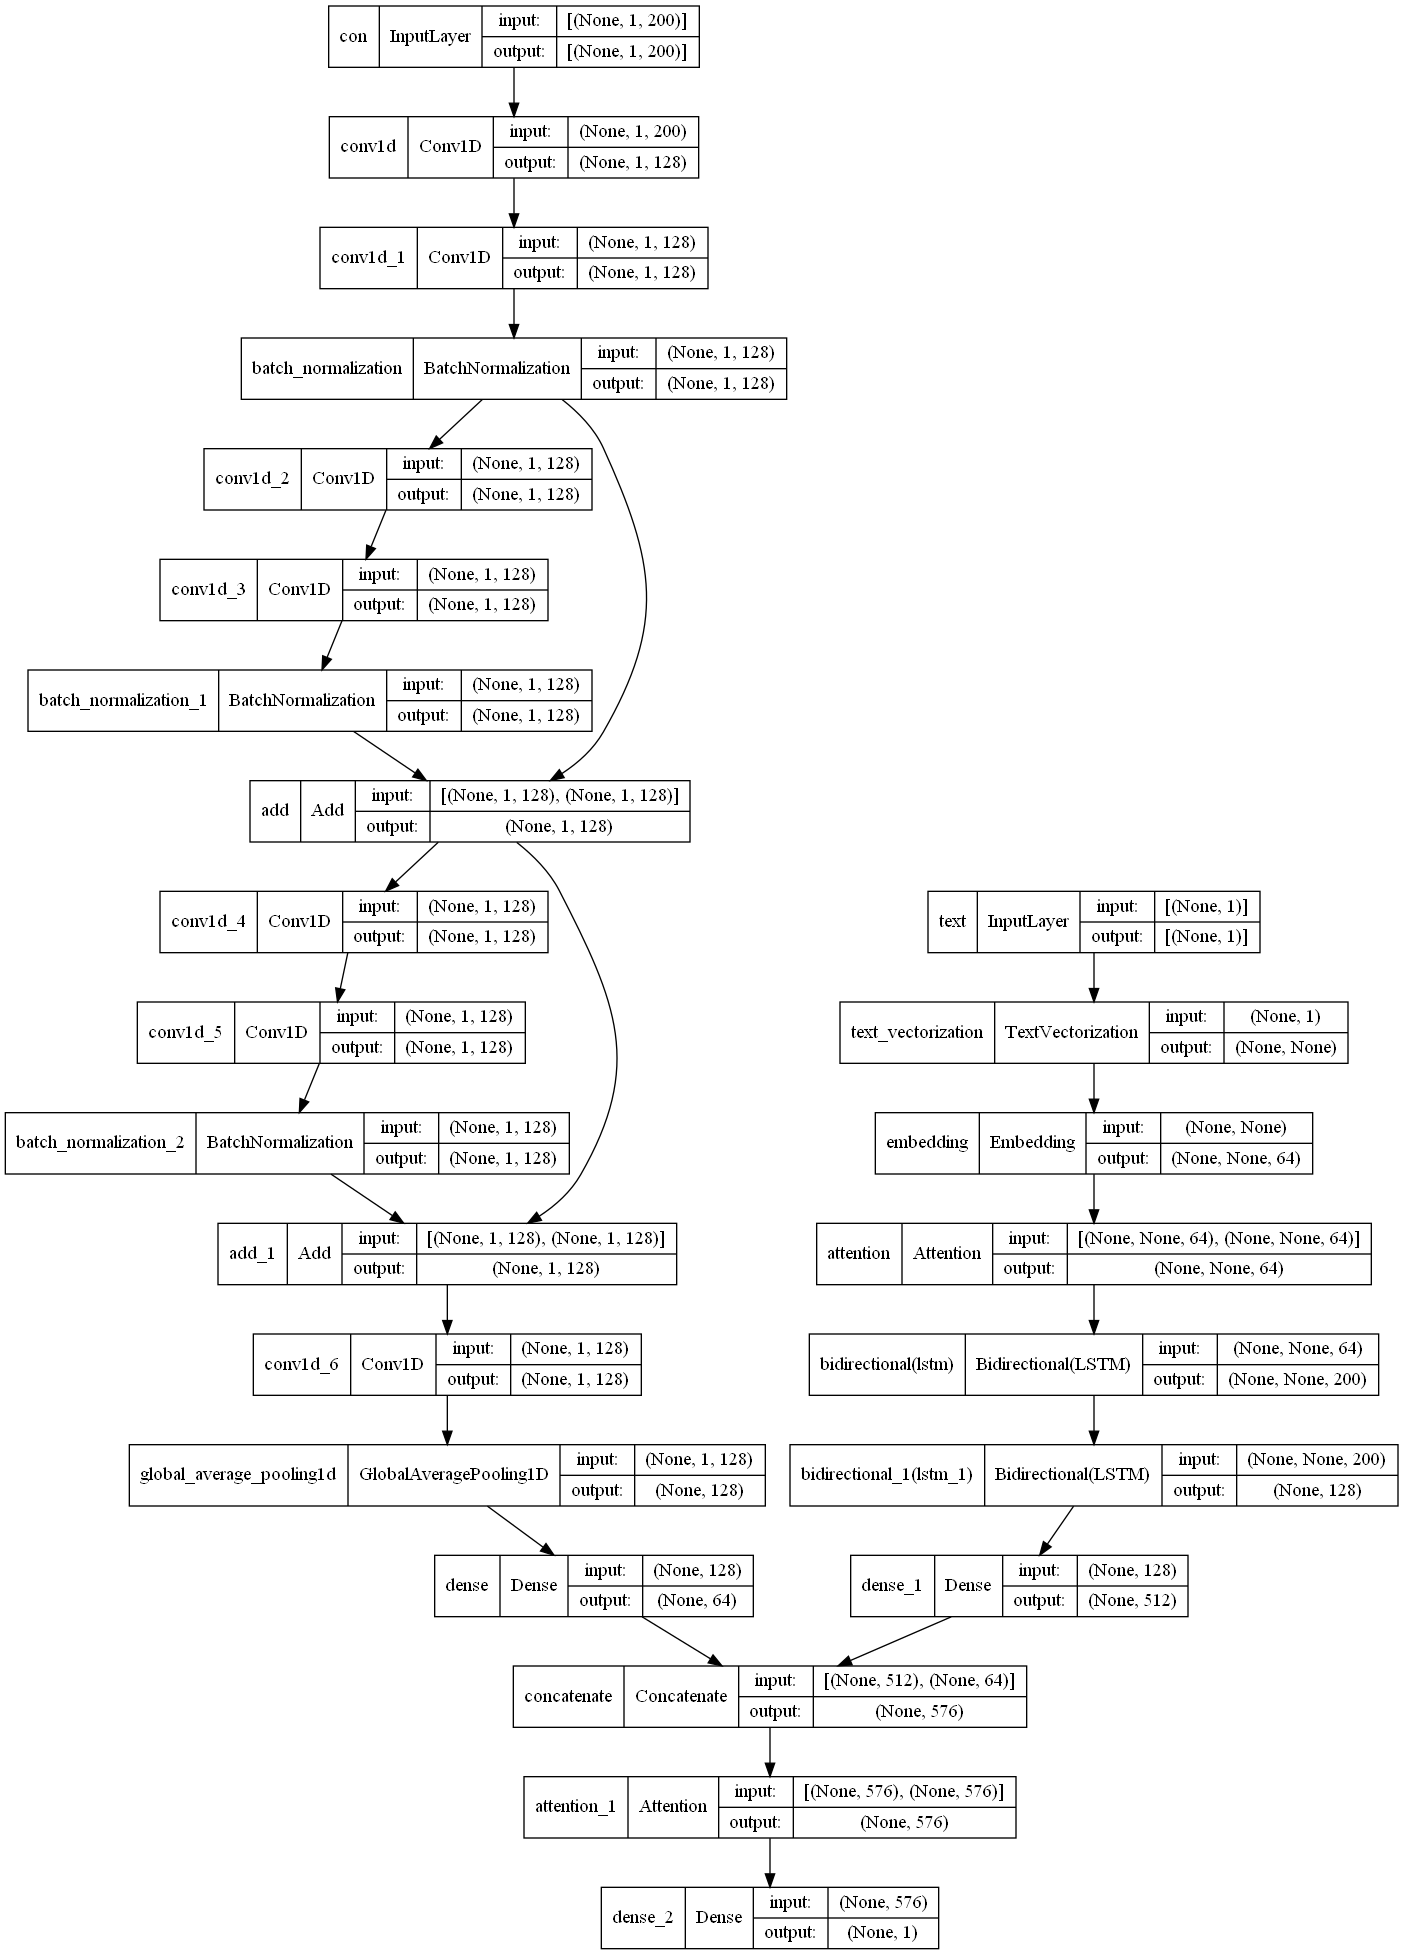

In [5]:
def load_model():
        global encoder
        kernel_num=128
        kernel_size_1=1
        kernel_size_2=1
        kernel_size_3=1
        input_con=tf.keras.Input(shape=(1,200),name='con')
        y=tf.keras.layers.Conv1D(kernel_num,kernel_size=kernel_size_1,strides=1,padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_con)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_1,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        
        block1_output=tf.keras.layers.BatchNormalization()(y)

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block1_output)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)

        y=tf.keras.layers.BatchNormalization()(y)
        
        block2_output=tf.keras.layers.add([y,block1_output])

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block2_output)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.BatchNormalization()(y)
        
        block3_output=tf.keras.layers.add([y,block2_output])
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(block3_output)

        y=tf.keras.layers.GlobalAveragePooling1D()(y)
        y=tf.keras.layers.Dense(64, activation='relu')(y)    

        input_text=tf.keras.Input(shape=(1,),dtype='string',name="text")
        encoder=tf.keras.layers.TextVectorization(max_tokens=100)
        encoder.adapt(feature_text)
        x=encoder(input_text)


        x=tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)(x)
        x=tf.keras.layers.Attention()([x,x])
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True))(x)
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
        x=tf.keras.layers.Dense(512, activation='relu')(x)

        feature_layer=tf.keras.layers.concatenate([x,y])
        att=tf.keras.layers.Attention()([feature_layer,feature_layer])
        output=tf.keras.layers.Dense(1)(att)
        model=tf.keras.Model([input_con,input_text],output)
        #model=tf.keras.Model([input_con],output)
        base_learning_rate = 0.001
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

        return model
model=load_model()
tf.keras.utils.plot_model(model,show_shapes=True)

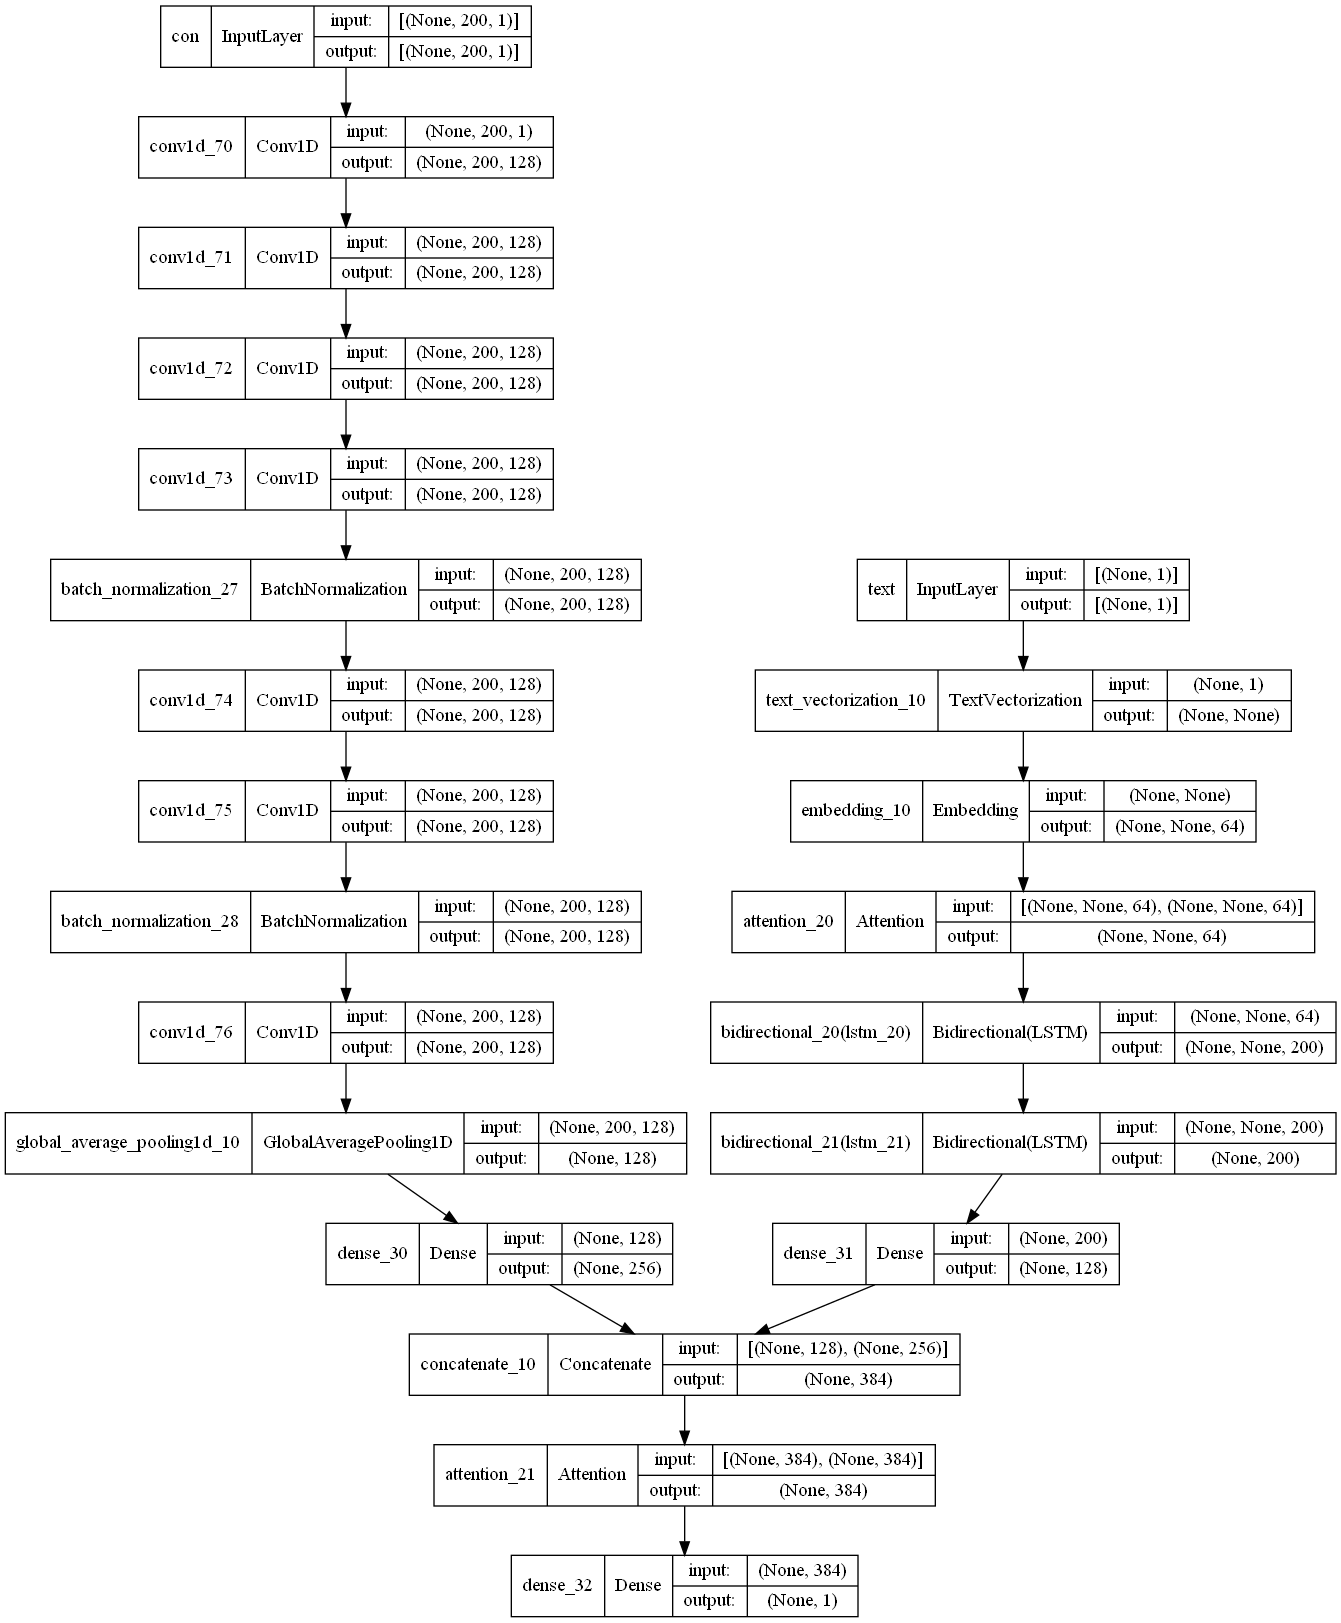

In [23]:
def load_model():
        global encoder
        kernel_num=128
        kernel_size_1=1
        kernel_size_2=2
        kernel_size_3=2
        input_con=tf.keras.Input(shape=(200,1),name='con')
        y=tf.keras.layers.Conv1D(kernel_num,kernel_size=kernel_size_1,strides=1,padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_con)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_1,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_2,strides=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)

        y=tf.keras.layers.BatchNormalization()(y)
        
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=kernel_size_3, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)
        y=tf.keras.layers.BatchNormalization()(y)
        

        y=tf.keras.layers.Conv1D(kernel_num, kernel_size=1, padding='same', activation=tf.nn.relu,kernel_regularizer=tf.keras.regularizers.l2(0.01))(y)

        y=tf.keras.layers.GlobalAveragePooling1D()(y)
        y=tf.keras.layers.Dense(256, activation='relu')(y)    

        input_text=tf.keras.Input(shape=(1,),dtype='string',name="text")
        encoder=tf.keras.layers.TextVectorization(max_tokens=100)
        encoder.adapt(feature_text)
        x=encoder(input_text)


        x=tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)(x)
        x=tf.keras.layers.Attention()([x,x])
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100,return_sequences=True))(x)
        x=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100))(x)
        x=tf.keras.layers.Dense(128, activation='relu')(x)

        feature_layer=tf.keras.layers.concatenate([x,y])
        att=tf.keras.layers.Attention()([feature_layer,feature_layer])

        output=tf.keras.layers.Dense(1)(att)

        model=tf.keras.Model([input_con,input_text],output)
        base_learning_rate = 0.001
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
        try:
            model.save("t.h5")
        except:
            pass
        return model
model=load_model()
tf.keras.utils.plot_model(model,show_shapes=True)

In [6]:
def train(index):    
    epochs=200
    min_loss=100
    text={}
    for i in range(epochs):
        if i<50:
            lr=0.001
        elif i<80:
            lr=0.0005
        else:
            lr=0.0001
            
        def scheduler(epoch):
            # 前5个epoch学习率保持不变，5个epoch后学习率按比例衰减
            return lr
        reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

        print(f"index:{index},epochs:{i}")
        history=model.fit(each_fold_train_x,each_fold_train_y,shuffle=True,epochs=1,batch_size=128,validation_data=(each_fold_val_x,each_fold_val_y),callbacks=[reduce_lr])
        if history.history["val_loss"][0]<=min_loss:
            try:
                min_loss=history.history["val_loss"][0]
                text=returnAccuracy2()
            except:
                pass
        print(text)
    record.append(text) 



In [7]:
po_test=test_x.copy()
po_test["con"]=po_test["con"][0:100]
po_test["text"]=po_test["text"][0:100]
ne_test=test_x.copy()
ne_test["con"]=ne_test["con"][100:200]
ne_test["text"]=ne_test["text"][100:200]
def evaluate(x,y):
    res=model.predict(x)
    t=np.array(tf.nn.sigmoid(res),dtype="float32")
    co=0
    num=y.shape[0]
    for i in range(num):
        if int(t[i][0]+0.5)==y[i]:
            co+=1
    return co/num
def returnAccuracy2():
    import math
    TP=evaluate(po_test,test_y[0:100])
    TN=evaluate(ne_test,test_y[100:])
    FP=1-TN
    FN=1-TP
    SN=TP/(TP+FN)
    SP=TN/(TN+FP)
    ACC=(TP+TN)/(TP+TN+FN+FP)
    MCC=(TP*TN-FP*FN)/math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
    text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
    return text

In [8]:
record=[]
for i in range(0,10):
    fold_order=i
    (train_index,val_index)=index_list[fold_order]
    each_fold_train_x={"con":train_con[train_index],"text":train_text[train_index]}
    each_fold_train_y=train_y[train_index]
    each_fold_val_x={"con":train_con[val_index],"text":train_text[val_index]}
    each_fold_val_y=train_y[val_index]
    model=load_model()
    train(i)
print(record)

index:0,epochs:0
11/11 [==============================] - 16s 433ms/step - loss: 9.7280 - accuracy: 0.4757 - val_loss: 9.4709 - val_accuracy: 0.4899 - lr: 0.0010
{}
index:0,epochs:1
11/11 [==============================] - 1s 108ms/step - loss: 9.2194 - accuracy: 0.4861 - val_loss: 9.0749 - val_accuracy: 0.4899 - lr: 0.0010
{}
index:0,epochs:2
11/11 [==============================] - 1s 107ms/step - loss: 8.6533 - accuracy: 0.5011 - val_loss: 8.4890 - val_accuracy: 0.4899 - lr: 0.0010
{}
index:0,epochs:3
11/11 [==============================] - 1s 109ms/step - loss: 8.2263 - accuracy: 0.4959 - val_loss: 7.9799 - val_accuracy: 0.5034 - lr: 0.0010
{}
index:0,epochs:4
11/11 [==============================] - 1s 107ms/step - loss: 7.8204 - accuracy: 0.5154 - val_loss: 7.6084 - val_accuracy: 0.4161 - lr: 0.0010
{}
index:0,epochs:5
11/11 [==============================] - 1s 107ms/step - loss: 7.4041 - accuracy: 0.5513 - val_loss: 7.3176 - val_accuracy: 0.4899 - lr: 0.0010
{}
index:0,epochs:

KeyboardInterrupt: 

In [ ]:
{'ACC': 0.66, 'SP': 0.55, 'SN': 0.77, 'MCC': 0.3280369472418919}

{'ACC': 0.675, 'SP': 0.7, 'SN': 0.65, 'MCC': 0.3504383220252312}

In [ ]:
ACC=0
SP=0
SN=0
MCC=0
for i in record:
    ACC+=i["ACC"]
    SP+=i["SP"]
    SN+=i["SN"]
    MCC+=i["MCC"]
ACC/=10
SP/=10
SN/=10
MCC/=10
text={"ACC":ACC,"SP":SP,"SN":SN,"MCC":MCC}
print(text)

In [ ]:
count=0
for index,i in enumerate(record):
    try:
        ACC="{:.2f}".format(i['ACC']*100)
        SP="{:.2f}".format(i['SP']*100)
        SN="{:.2f}".format(i['SN']*100)
        MCC="{:.3f}".format(i['MCC'])
        text=f"{index+1} & {ACC} & {SP} & {SN} & {MCC} \\\\"
        print(text)
        count+=1
    except:
        pass
ACC=0
SP=0
SN=0
MCC=0
for i in record:
    try:
        ACC+=i["ACC"]
        SP+=i["SP"]
        SN+=i["SN"]
        MCC+=i["MCC"]
    except:
        pass
ACC/=count
SP/=count
SN/=count
MCC/=count
ACC="{:.2f}".format(ACC*100)
SP="{:.2f}".format(SP*100)
SN="{:.2f}".format(SN*100)
MCC="{:.3f}".format(MCC)
text=f"Mean & {ACC} & {SP} & {SN} & {MCC} \\\\"
print(text)